# **6.047 | 6.878 | HST.507**

#**Fall 2020 Problem Set 3: Motifs and RNA Structures**

Due: Monday, October 19 at 11:59PM (submit copy of notebook to Stellar)

#Load libraries


In [2]:
!pip install logomaker
from google.colab import files
from IPython.display import Image, display
import logomaker, math, random, string, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

     |████████████████████████████████| 11.8 MB 121 kB/s 


# Gibbs sampling for motif discovery

In this problem, you will implement a Gibbs sampler to discover sequence motifs.

A) Recall the Gibbs sampling algorithm for this problem: Initialize the motif position in each sequence. Until convergence: re-estimate the position weight matrix (PWM) from all the motifs except one, score every position in the excluded sequence, and sample a $k$-mer from the excluded sequence with probability proportional to the score.

We have intentionally not specified many of the implementation details. Describe and justify the design decisions you made in your implementation. For example, how do you choose the sequence to exclude when recomputing the position weight matrix?

In [13]:
alphabet = ['A', 'C', 'G', 'T']

### GibbsSampler:
### INPUTS:	S - list of sequences
###		    L - length of motif
###	OUTPUT:	PWM - 4 x L list with frequencies of each base at each position
###               Order of bases should be consistent with alphabet variable
def GibbsSampler(S, L):
    PWM = [[0 for _ in range(L)] for _ in range(len(alphabet))]
    Z=[np.random.choice(len(S[_])-L) for _ in range(len(S))]
    X=np.random.choice(len(S))
    # bkg=[0 for _ in range(len(alphabet))]
    bkg_p=0.25**L
    stop=False
    stopper=0
    step=0

    while not stop:
      step+=1
      old_Z=Z[X]
      pseudocount=1/(len(S)-1+len(alphabet))
      PWM = [[pseudocount for _ in range(L)] for _ in range(len(alphabet))]
      # bkg=[0 for _ in range(len(alphabet))]
      motif_p=1
      # bkg_p=1

      #update PWM
      # num=0
      for i in range(len(S)):
        if i==X:
          continue

        start=Z[i]

        for index in range(L):
          PWM[alphabet.index(S[i][start+index])][index]+=1/(len(S)-1+len(alphabet))
          # else:
          #   bkg[alphabet.index(S[i][index])]+=1
          #   num+=1


      #find and set pseudocounts for PWM, calculate probabilities of PWM and bkg
      # for x in range(len(PWM)):
      #   for i in range(len(PWM[x])):
      #     PWM[x][i]+=4
      #     PWM[x][i]/=(len(S)-1)+len(alphabet)*4
        # bkg[x]/=num

      #recalculate starting positions for sequence X
      Z_x=[]
      for i in range(len(S[X])-L):
        for index in range(L):
          motif_p*=PWM[alphabet.index(S[X][i+index])][index]
          # bkg_p*=bkg[alphabet.index(S[X][i+index])]
        Z_x.append(motif_p/bkg_p)
        motif_p=1
        # bkg_p=1
      
      #normalize probabilities of Z_x
      s=0
      for i in Z_x:
        s+=i
      Z_x=[i/s for i in Z_x]
      
      #set new starting position for sequence X
      Z[X]=np.random.choice(range(len(S[X])-L),p=Z_x)

      if old_Z==Z[X]:
        stopper+=1
      if stopper>=(L//3):
        # print(step)
        stop=True

      #pick a new sequence X
      old_X=X
      while X==old_X:
        X=np.random.choice(len(S))
    
    for x in range(len(PWM)):
      for i in range(len(PWM[x])):
        motif_p=PWM[x][i]
        PWM[x][i]=math.log((motif_p/(1-motif_p))/(0.25/0.75))
    return PWM



###########################
# NO NEED TO MODIFY BELOW #
###########################

def get_motif_seq(PWM):
    motif_seq = ""
    for i in range(len(PWM[0])):
        comp = [row[i] for row in PWM]
        ind = max(range(len(comp)), key = comp.__getitem__)
        motif_seq += alphabet[ind]
    return motif_seq

def print_PWM(PWM, L):
    PWM_comp = []
    PWM_comp.append("||" + "|".join([str(i) for i in range(1, L + 1)]) + "|")
    PWM_comp.append("|-" * (L + 1) + "|")
    for i in range(4):
        PWM_comp.append("|" + alphabet[i] + "|" + "|".join([str(round(val, 2)) for val in PWM[i]]) + "|")
    print("\n".join(PWM_comp) + "\n")

def print_logo(PWM):
    PWM = np.array(PWM).T
    PWM = pd.DataFrame(PWM, columns = alphabet)
    logomaker.Logo(PWM, fade_below = 0.8)

def run_GibbsSampler(S, L, n):
    motif_seqs, motif_PWM = {}, {}
    for i in range(n):
        PWM = GibbsSampler(S, L)
        motif_seq = get_motif_seq(PWM)
        motif_seqs.setdefault(motif_seq, 0)
        motif_seqs[motif_seq] += 1
        motif_PWM[motif_seq] = PWM
    best_motif = max(motif_seqs.keys(), key = lambda x: motif_seqs[x])
    print("Most consistent motif: \n" + best_motif + "\n")
    print("PWM (paste into text block):")
    print_PWM(motif_PWM[best_motif], L)
    print("Sequence logo:")
    print_logo(motif_PWM[best_motif])

Start by initializing a position weight matrix for the motif and a background matrix. Set initial starting positions for each sequence in $S$ at random.

Then repeatedly remove some sequence $X_i$ at random from $S$, calculate the PWM from remaining sequences, then choose a new starting position for $X_i$, sampling from the distribution $Z_{ij}$, where $Z_{ij}$ is the probability of sequence $X_i$ having its motif starting position at $j$. $Z_{ij}$ is calculated from the new PWM. We then select a new sequence to remove at random, ensuring that it is a different sequence from its predecessor. Once we reach a certain number of sequences which do not change motif starting positions after recalculating, we terminate the loop and return the PWM at that time.

You will need to download the following [files](https://www.dropbox.com/sh/ymt4j1cjvn1xdrj/AAA3tKLQdkDPFoAYOA9kdmwUa?dl=0) and upload them to colab using the following code block.

In [4]:
gibbs_motifs = files.upload()
for k, v in gibbs_motifs.items():
    gibbs_motifs[k] = v.decode("utf-8-sig").split()

Saving data2.txt to data2.txt
Saving data3.txt to data3.txt
Saving data1.txt to data1.txt
Saving data4.txt to data4.txt


B) We have provided four test cases. `data1` is a synthetic data set where
the motif is identical across the sequences. `data2` is a synthetic data set
with a degenerate motif. `data3` and `data4` are yeast transcription factor
binding sites of ACE2 and MBP1, respectively.

Run your Gibbs sampler on the test data to discover motifs of length 10. You will need to repeat this procedure several times on each data set due to the stochastic nature of Gibbs sampling.

Report the most consistently found PWM for each sequence.

Most consistent motif: 
AAAAAAAAAA

PWM (paste into text block):
||1|2|3|4|5|6|7|8|9|10|
|-|-|-|-|-|-|-|-|-|-|-|
|A|1.84|1.62|1.48|1.48|1.34|1.69|1.55|1.92|2.0|1.77|
|C|-1.08|-0.91|-0.75|-0.91|-2.96|-1.52|-2.25|-1.08|-1.83|-1.08|
|G|-0.91|-1.83|-1.52|-0.75|-0.07|-1.08|-0.91|-2.25|-1.28|-1.83|
|T|-1.08|-0.27|-0.27|-0.62|-0.37|-0.37|-0.07|-0.49|-0.62|-0.37|

Sequence logo:


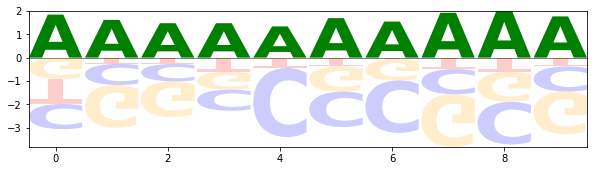

In [25]:
run_GibbsSampler(gibbs_motifs["data4.txt"], 10, 100)

`data1` PWM:

||1|2|3|4|5|6|7|8|9|10|
|-|-|-|-|-|-|-|-|-|-|-|
|A|1.91|-0.61|-0.61|-1.39|-1.39|2.3|1.91|-0.61|-1.39|-0.61|
|C|-1.39|-1.39|-1.39|1.91|-1.39|-1.39|-0.61|-1.39|-1.39|1.91|
|G|-0.61|-1.39|-1.39|-0.61|1.91|-1.39|-1.39|-1.39|-1.39|-1.39|
|T|-1.39|1.91|1.91|-1.39|-0.61|-1.39|-1.39|1.91|2.3|-1.39|

`data2` PWM:

||1|2|3|4|5|6|7|8|9|10|
|-|-|-|-|-|-|-|-|-|-|-|
|A|-0.61|-0.61|-0.11|0.29|-1.39|-1.39|-0.11|1.91|-0.61|-1.39|
|C|-1.39|1.57|-1.39|-1.39|-0.61|2.3|-1.39|-1.39|1.91|-1.39|
|G|-1.39|-1.39|-1.39|1.25|-1.39|-1.39|-1.39|-1.39|-1.39|-1.39|
|T|1.91|-0.61|1.57|-1.39|1.91|-1.39|1.57|-0.61|-1.39|2.3|

`data3` PWM:

||1|2|3|4|5|6|7|8|9|10|
|-|-|-|-|-|-|-|-|-|-|-|
|A|1.96|0.72|1.96|2.55|0.83|1.71|1.71|2.23|1.15|1.26|
|C|-1.33|-1.33|-0.76|-2.48|-1.76|-1.33|-0.76|-2.48|-0.76|-1.33|
|G|-0.76|0.49|-2.48|-1.33|-1.01|-0.19|-0.76|-0.76|-2.48|0.11|
|T|-1.33|-0.54|-0.76|-1.33|0.72|-1.76|-1.33|-1.33|0.36|-1.01|

`data4` PWM:

||1|2|3|4|5|6|7|8|9|10|
|-|-|-|-|-|-|-|-|-|-|-|
|A|1.84|1.62|1.48|1.48|1.34|1.69|1.55|1.92|2.0|1.77|
|C|-1.08|-0.91|-0.75|-0.91|-2.96|-1.52|-2.25|-1.08|-1.83|-1.08|
|G|-0.91|-1.83|-1.52|-0.75|-0.07|-1.08|-0.91|-2.25|-1.28|-1.83|
|T|-1.08|-0.27|-0.27|-0.62|-0.37|-0.37|-0.07|-0.49|-0.62|-0.37|


# Evolutionary signatures of motifs

In this problem, you will search for enriched (over-represented) $k$-mers in regions conserved across the yeast clade *Saccharomyces*.

You will need to download the following [files](https://www.dropbox.com/sh/tx0p18sx4daw50t/AAC5_T1bRboHw_Di7sjxgpuya?dl=0) and upload them to colab using the following code block.

In [ ]:
intergenic = files.upload()
for k, v in intergenic.items():
    intergenic[k] = v.decode("utf-8-sig")

Saving allintercons to allintercons
Saving allinter to allinter


A) We have provided the sequence of all intergenic regions in S. *cerevisiae* in
`allinter`. We have also provided an annotation of conservation in `allintercons`. Each position marked with * (everything else is considered nonconserved) corresponds to a conserved nucleotide. For simplicity, we will look for motifs which are non-degenerate, exact matches. In other words, a conserved motif consists entirely of conserved nucleotides.

Compute the frequency and conservation of all 6-mers. Report the 50 most frequently occurring and 50 most conserved motifs (those with the highest proportion of conserved instances) as python lists.

In [ ]:
# Intergenic regions: intergenic["allinter"]
# Annotation of conservation: intergenic["allintercons"]

bases=set(['A','T','C','G'])
lookup={}
for i in range(len(intergenic["allinter"])-6+1):
    key = intergenic["allinter"][i:i + 6]
    cons = set(intergenic["allintercons"][i:i + 6])
    if len(set(key).difference(bases)):
      continue
    if key in lookup:
      lookup[key][0]+=1
    else:
      lookup[key]=[1,0]
    if not cons.difference(set('*')):
      lookup[key][1]+=1
kmers=list(lookup.keys())
freq=sorted(kmers, reverse=True, key=lambda k: lookup[k][0])[:50]
conserv=sorted(kmers, reverse=True, key=lambda x: lookup[x][1]/lookup[x][0])[:50]

print(freq)
print(conserv)

['AAAAAA', 'TTTTTT', 'TATATA', 'ATATAT', 'AAAAAT', 'ATTTTT', 'GAAAAA', 'TTTTTC', 'AAAATA', 'TAAAAA', 'AATAAA', 'ATAAAA', 'TATTTT', 'AAGAAA', 'AAATAA', 'CTTTTT', 'AGAAAA', 'TTTCTT', 'TTATTT', 'AAAAAG', 'TTTTTA', 'TTTTAT', 'TTTATT', 'TTTTCT', 'AAAGAA', 'ATAATA', 'TTCTTT', 'ATATAA', 'TATTAT', 'AATATA', 'TCTTTT', 'AAATAT', 'ATATTT', 'AAAAGA', 'TTATAT', 'AATTTT', 'TATATT', 'AAAATT', 'AATAAT', 'AATATT', 'TAAATA', 'ATTATT', 'AAATTT', 'TATAAA', 'TAATAA', 'ATATTA', 'TATTTA', 'TAATAT', 'TTTATA', 'ATAAAT']
['CGGGTA', 'TACCCG', 'CCGGGT', 'ACCCGG', 'CACGTG', 'ACGCGT', 'GGGTAA', 'TTACCC', 'GCGGCT', 'CGCGTC', 'CGGCTA', 'CTCATC', 'GCGATG', 'CACCCG', 'GATGAG', 'GCGGGT', 'CGATGA', 'TTCGCG', 'GAGTCA', 'GCGCGA', 'GGGTGG', 'TCATCG', 'GGCGGC', 'ACCCGC', 'GCCCCT', 'TGGGTG', 'CAGGGG', 'GCCGCC', 'CCGATA', 'TCGCGT', 'GTCGAC', 'GTCGCG', 'CGTCGC', 'CATCGC', 'GACGCG', 'TAGCCG', 'ACGCGA', 'CCCGAG', 'CTCGAG', 'CCCCTG', 'GGTTCG', 'CGCGTT', 'GGAGTC', 'AGCCGC', 'CCGAGC', 'CGGCGG', 'TGACTC', 'AACGCG', 'CGCGAG', 'GTACGG'

Most frequently occurring: ['AAAAAA', 'TTTTTT', 'TATATA', 'ATATAT', 'AAAAAT', 'ATTTTT', 'GAAAAA', 'TTTTTC', 'AAAATA', 'TAAAAA', 'AATAAA', 'ATAAAA', 'TATTTT', 'AAGAAA', 'AAATAA', 'CTTTTT', 'AGAAAA', 'TTTCTT', 'TTATTT', 'AAAAAG', 'TTTTTA', 'TTTTAT', 'TTTATT', 'TTTTCT', 'AAAGAA', 'ATAATA', 'TTCTTT', 'ATATAA', 'TATTAT', 'AATATA', 'TCTTTT', 'AAATAT', 'ATATTT', 'AAAAGA', 'TTATAT', 'AATTTT', 'TATATT', 'AAAATT', 'AATAAT', 'AATATT', 'TAAATA', 'ATTATT', 'AAATTT', 'TATAAA', 'TAATAA', 'ATATTA', 'TATTTA', 'TAATAT', 'TTTATA', 'ATAAAT']


Most conserved: ['CGGGTA', 'TACCCG', 'CCGGGT', 'ACCCGG', 'CACGTG', 'ACGCGT', 'GGGTAA', 'TTACCC', 'GCGGCT', 'CGCGTC', 'CGGCTA', 'CTCATC', 'GCGATG', 'CACCCG', 'GATGAG', 'GCGGGT', 'CGATGA', 'TTCGCG', 'GAGTCA', 'GCGCGA', 'GGGTGG', 'TCATCG', 'GGCGGC', 'ACCCGC', 'GCCCCT', 'TGGGTG', 'CAGGGG', 'GCCGCC', 'CCGATA', 'TCGCGT', 'GTCGAC', 'GTCGCG', 'CGTCGC', 'CATCGC', 'GACGCG', 'TAGCCG', 'ACGCGA', 'CCCGAG', 'CTCGAG', 'CCCCTG', 'GGTTCG', 'CGCGTT', 'GGAGTC', 'AGCCGC', 'CCGAGC', 'CGGCGG', 'TGACTC', 'AACGCG', 'CGCGAG', 'GTACGG']


B) Compare frequently occurring motifs to highly conserved motifs. Are there biases in the sequence properties of either class? If so, where does this bias come from?

Which of the two lists should we use to direct further inquiry into yeast transcription factor binding sites? Provide justification.

The most frequent motifs are higher in AT-frequency while the most conserved motifs are higher in GC-frequency. The most frequent motifs are the poly-A and poly-T sequences, and are in general characterized by lower complexity than the most conserved motifs. This bias is due to the prevalence of simple repeating sequences in genomic sequences that are not correlated with a functional motif.

We should investigate the most conserved list because TF binding sites have a high likelihood of being conserved in the genome since they serve an essential biological function. The dysfunction of TF binding sites likely confers an unfavorable phenotype, placing evolutionary pressure to conserve TF binding sites.

# RNA secondary structure

In this problem we will explore the output of the Nussinov algorithm on random
RNA sequences.

A) Implement the Nussinov algorithm, scoring A-U, G-U, and C-G pairs as -1 and all other pairs as 0.

In [ ]:
				 #  A   U   C   G
scoring_matrix = [[ 0, -1,  0,  0], # A
				  [-1,  0,  0, -1], # U
				  [ 0,  0,  0, -1], # C
				  [ 0, -1, -1,  0]] # G
b_map = {'A': 0, 'U': 1, 'C': 2, 'G': 3}

def nussinov(seq):
	E=[[None for i in range(len(seq))] for x in range(len(seq))]
	E_mid=None
	E_post=None

	for i in range(len(seq)):
		E[i][i]=0
		
	for i in range(len(seq)-2,-1,-1):
		for x in range(i+1):
			if i-x+1>len(seq)-x-2:
				E_mid=0
			else:
				E_mid=E[i-x+1][len(seq)-x-2]
			if len(seq)-x>len(seq)-x-1:
				E_post=0
			else:
				E_post=E[len(seq)-x][len(seq)-x-1]
			E[i-x][len(seq)-x-1] = min(E[i-x+1][len(seq)-x-1], (scoring_matrix[b_map[seq[i-x]]][b_map[seq[len(seq)-x-1]]]+E_mid+E_post))
	
	return E[0][len(seq)-1]

B) Generate 1000 RNA sequences of length 100 where each base is drawn
uniformly at random. What is the average score for these sequences?

In [ ]:
def gen_seq(L):
    bases = ['A', 'U', 'C', 'G']
    return ''.join([random.choice(bases) for _ in range(L)])

def nussinov_avg(L, n):
    cum_score = 0
    for _ in range(n):
        cum_score += nussinov(gen_seq(L))
    return cum_score / n

In [ ]:
nussinov_avg(100, 1000)

-31.912

C) How does the score vary as a function of length? (You will need to repeat (B) for various lengths.)

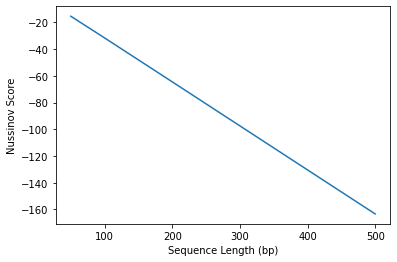

In [ ]:
x=[50,100,200,500]
y=[nussinov_avg(50, 1000),nussinov_avg(100, 1000),nussinov_avg(200, 1000),nussinov_avg(500, 1000)]

plt.xlabel("Sequence Length (bp)")
plt.ylabel("Nussinov Score")
plt.plot(x, y)

The Nussinov score is proportional to length.

D) How does the score vary as a function of GC content? Is this function symmetric around GC content equal to 0.5? Why or why not? (You will need to repeat (B) for different distributions from which you draw bases.)

In [ ]:
def gen_seq(L, freq):
    bases = ['A', 'U', 'C', 'G']
    freq2=1-freq
    return ''.join([np.random.choice(bases, p=[freq2/2,freq2/2,freq/2,freq/2]) for _ in range(L)])

def nussinov_avg(L, freq, n):
    cum_score = 0
    for _ in range(n):
        cum_score += nussinov(gen_seq(L,freq))
    return cum_score / n

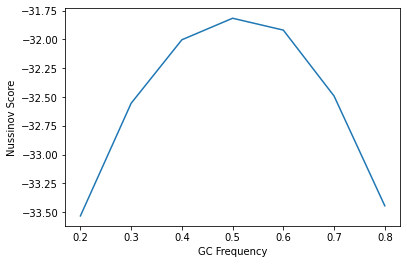

In [ ]:
x=[0.2,0.3,0.4,0.5,0.6,0.7,0.8]
y=[nussinov_avg(100, 0.2,1000),nussinov_avg(100, 0.3,1000),nussinov_avg(100, 0.4,1000),nussinov_avg(100, 0.5, 1000),nussinov_avg(100, 0.6,1000),nussinov_avg(100, 0.7,1000),nussinov_avg(100, 0.8,1000)]

plt.xlabel("GC Frequency")
plt.ylabel("Nussinov Score")
plt.plot(x, y)

The function is approximately symmetric about a GC frequency of 0.5, since sampling more frequently from AT or GC instead of from all four bases results in higher likelihood of any two bases being able to pair. However, the difference between GC = 0.5 and GC = 0.8 is still quite small (<2).

E) Given an RNA transcript of interest, how should you interpret the score output by the Nussinov algorithm with respect to your observations about its dependence on length and sequence composition? Is there a better way to estimate the effect of these biases on the score?

To compare RNA transcripts, we can normalize their scores by their lengths, since they are linearly correlated. Sequence composition does not produce a large difference, but we can account for the little difference it does impart by weighing the pairing of the nucleotides based on the strength of their pairing (e.g. G-C bonds are -2 instead of -1), so that the sequence composition is more accurate to the free energy of the structure.

# (6.878 only) Probabilistic model for transcription factor binding sites

In this problem we will derive the probabilistic model underlying position weight matrices (PWMs) and use it to study CCCTC-binding factor (CTCF) binding sites. CTCF is a conserved zinc-finger protein which binds to thousands of locations in the human genome and acts as an insulator/repressor.

A) Explain how to estimate the motif model $M = [m_{ij}]$ where $m_{ij} = P(position~i = nucleotide~j)$.

**Answer here:**

B) Describe and justify an algorithm to estimate the background model $B$. What assumptions does your model make? What are some of its weaknesses?

**Answer here:**

You will need to download the following [files](https://www.dropbox.com/sh/uqqqvlxe6udrc56/AACKMsRAFc6JxH8z0Qpg-YvGa?dl=0) and upload them (except `ctcf_motif.jpg`) to colab using the following code block.

In [ ]:
ctcf_data = files.upload()
for k, v in ctcf_data.items():
    ### YOUR CODE HERE ###

C) Recall that a PWM gives the log odds of observing a particular nucleotide at a particular position in the motif model against the background distribution.

Implement your algorithm from (A) to estimate $M$ from `ctcf_binding_site_sequences.txt` and your algorithm from (B) to estimate $B$ from `chr11_region.fa`. Then, estimate a PWM for CTCF using $M$ and $B$. Report all of the distributions.

In [ ]:
def estimate_model(""" YOUR PARAMETERS HERE """):

    ### YOUR CODE HERE ###

def estimate_background(""" YOUR PARAMETERS HERE """):

    ### YOUR CODE HERE ###

def estimate_pwm(""" YOUR PARAMETERS HERE """):

    ### YOUR CODE HERE ###

**Answer here:**

$M$:

$B$:

PWM:

D) An alternative visual representation of transcription factor binding sites is a sequence logo which gives the information content at every position (intuitively, how important each position is for protein binding affinity).

Use the `logomaker` (already imported) library to generate a sequence logo for `ctcf_binding_site_sequences.txt`. You may find these `logomaker` [tutorials](https://github.com/jbkinney/logomaker/tree/master/logomaker/tutorials) to be useful.

In [ ]:
### YOUR CODE HERE ###

E) Compare your sequence logo to the published logo `ctcf_motif.jpg`. What could account for any differences?

**Answer here:**

F) Discuss the limitations of PWMs as a representation of transcription factor binding sites. What assumptions are made? Do they hold in general?

**Answer here:**

G) Because the entries of a PWM are log odds scores, we can score a $k$-mer by simply adding up the appropriate entries of the PWM.

Convert the published Position Frequency Matrix (PFM) `ctcf_pfm.txt` to a PWM and use it to scan for CTCF binding sites in `chr11_region.fa`.

This region flanks the gene insulin-like growth factor 2 (*IGF2*). Plot the scores at every position for each strand. You may find the `matplotlib.pyplot` package (already imported) to be useful.

In [ ]:
### YOUR CODE HERE ###

H) Recall that short $k$-mers frequently occur by chance throughout the genome. Estimate the probability distribution of scores by randomly sampling 1 million  20-mers from chromosome 11 and scoring them using your PWM from (G). You may want to use the [full sequence](ftp://hgdownload.cse.ucsc.edu/goldenPath/hg19/chromosomes/chr11.fa.gz) of chromosome 11 rather than the region we have provided. Plot a histogram of this distribution. Again, you may find the `matplotlib.pyplot` package (already imported) to be useful.

A simple way to use this null distribution to filter out hits that occurred by chance is to only keep hits with $P(score > threshold) < 10^{-5}$. Based on the distribution you estimated, what is the threshold?

Report the location, score, and sequence (be sure to
account for strand orientation) of each 20-mer which meets the threshold in a table.

In [ ]:
### YOUR CODE HERE ###

**Answer here:**

|Start|End|Score|Sequence|
|-|-|-|-|

I) Discuss some limitations of filtering PWM matches in this manner. Does the method by which we sample 20-mers matter? How will the sequence properties of randomly chosen genomic regions affect the answer? Can we choose regions in a more principled way to account for sequence properties? Is it possible to estimate the probability of a PWM match occurring by chance without sampling?

**Answer here:**